In [1]:
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
import random
import math
import copy
from typing import Annotated, Any, Callable
from pydantic import BaseModel, Field, WithJsonSchema
import pydantic
import ipywidgets as widgets
import random


In [19]:
%load_ext autoreload
%autoreload 2

import sys
for p in ['../src']:
    if p not in sys.path:
        sys.path.append(p)
        
import spikeml as sml
from spikeml.utils.nb_util import xdisplay, Markup
from spikeml.core.signal import signal_dc, signal_pulse, encode1_onehot, encode_onehot, signal_ranges, mean_per_input
from spikeml.core.ngram import build_ngram, ngram_find, ngram_msample, print_ngrams

from spikeml.plot.plot_util import plot_hist, plot_data, plot_lidata, plot_input, plot_xt, plot_mt, plot_spikes, imshow_matrix, imshow_nmatrix
from spikeml.core.params import Params, NNParams, ConnectorParams, SpikeParams, SSensorParams, SNNParams, SSNNParams

from spikeml.core.params import Params, NNParams, ConnectorParams, SpikeParams, SSensorParams, SNNParams, SSNNParams
from spikeml.ui.ipywidgets_ui import ui

from spikeml.core.matrix import matrix_split, normalize_matrix, _mult, cmask, cmask2, matrix_init, matrix_init2
from spikeml.core.monitor import Monitor

from spikeml.core.spikes import pspike, spike
from spikeml.core.base import Component, Module, Fan, Composite, Chain
from spikeml.core.snn import Layer, SimpleLayer, LinearLayer, SNN, SSNN, SSensor, DSSNN, Connector, LinearConnector, RateConnector, LIConnector, LIConnector2
from spikeml.core.chain import make_snn_chain, make_ssnn_chain, chain_validate
from spikeml.core.snn import ssnn_apply_update
from spikeml.core.feedback import compute_error, xcompute_error, compute_sg
from spikeml.core.run import run, nrun, Context

from spikeml.core.optimize import make_params_spec, vec2dic, setattrs, params_search, set_all_attrs

from spikeml.core.snn_monitor import SSensorMonitor, LayerMonitor, SNNMonitor, SSNNMonitor, ConnectorMonitor, LIConnectorMonitor
from spikeml.core.snn_viewer import  SSensorMonitorViewer, LayerMonitorViewer, SNNMonitorViewer, SSNNMonitorViewer, ConnectorMonitorViewer, LIConnectorMonitorViewer, ErrorMonitorViewer
from spikeml.core.snn_stats import connector_stats, htest_connections, htest_connector_identity
from spikeml.core.snn_stats_viewer import plot_snn_stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SEED=37
random.seed(SEED)
np.random.seed(SEED)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=120, nanstr='nan', precision=4, suppress=False, threshold=1000, formatter=None)


In [ ]:
def test_conn_update(T=10,  log_step=1, debug=True):
    params = SSNNParams(g=1, e_err=5, t_p=2, pmax=1, e_z=2, c_k=3, c_in=0, c_out=0, cmin=0, cmax=2)
    print(params.fmt())
    def _test(zs, zy):
        M = np.array([[.1,.1], [.1, .1]])
        Cp, Cn =None,None 
        Cp_, Cn_, Zp_, Zn_, Wp_, Wn_, dM_, dMp_, dMn_ = np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape)
        for t in range(T):
            debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
            if debug_:
                print(f't={t}', 'zs:', zs, 'zy:', zy)
            M, Cp, Cn, dM, dMp, dMn, Zp, Zn, Wp, Wn = conn_update(M, Cp, Cn, zy, zs, params=params, debug=False)
            if debug_:
                xdisplay(Markup('M', M), Markup('Cp', Cp), Markup('Cn', Cn), Markup('Zp', Zp), Markup('Zn', Zn), Markup('Wp', Wp), Markup('Wn_', Wn), Markup('dM', dM), Markup('dMp', dMp), Markup('dMn', dMn))
            Cp_ += Cp
            Cn_ += Cn
            Zp_ += Zp
            Zn_ += Zn
            Wp_ += Wp
            Wn_ += Wn
            dM_ += dM
            dMp_ += dMp
            dMn_ += dMn
        if debug:
            print('zs:', zs, 'zy:', zy)
            xdisplay(Markup('M', M), Markup('Cp_', Cp_), Markup('Cn_', Cn_), Markup('Zp_', Zp_), Markup('Zn_', Zn_), Markup('Wp_', Wp_), Markup('Wn_', Wn_), Markup('dM_', dM_), Markup('dMp_', dMp_), Markup('dMn_', dMn_))
    
    zs = np.array([1,0])
    zy = np.array([1,0])
    _test(zs, zy)
    zy = np.array([0,1])
    _test(zs, zy)
    zy = np.array([1,1])
    _test(zs, zy)

test_conn_update(T=20, log_step=-1)


SSNNParams({'c_k': 3.0, 't_c': 10, 't_p': 2.0, 't_d': 5, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
zs: [1 0] zy: [1 0]


zs: [1 0] zy: [0 1]


zs: [1 0] zy: [1 1]


In [129]:
def __test_cov_update():
    #M = np.array([[0.1,0.1], [0.1, 0.1]])
    #M = np.array([[1,1], [1, 1]])
    #M = np.array([[.9,0], [0, 0]])
    M = np.array([[.7,-0.1], [.3, 0.1]])
    M = np.array([[ 0.6705, -0.0019],[ 0.3355,  0.0355]])
    M = np.array([[.1,.1], [.1, .1]])
    y = np.array([0, 1])
    s = np.array([1, 0])
    params = SSNNParams(cmax=1, t_p=1, t_d=10, c_in=-1, c_out=1)
    params = SSNNParams(g=2, pmax=.5, e_err=2, t_p=1, t_d=10,
                    t_b=0, t_tdp=1, e_z=3, vmin=0, vmax=1.1, cmax=1.5, cmin=-1.5, c_in=2, c_out= 2)
    print(params)
    print('s:', s, '; y:', y)
    for i in range(0,10):
        M, dM, dMp, dMn = cov_update(M, s, y, params=params, debug=True)
    

def test_ssnn_apply_update(T=1, N=1, size=2, R=1, ss=None, mean=.1, sd=0, feedback=True, params=None, log_step=1, debug=True, quite=False):
    if params is None:
        params = SSNNParams(g=1, e_err=5, t_p=1, t_d=5, pmax=1, e_z=2, c_k=3, c_in=0, c_out=0, cmin=0, cmax=2)
    if not quite:
        print(params)
    #params = SSNNParams(pmax=.5, c_k=2, t_p=1, t_d=3, t_b=0, t_tdp=5, e_z=3, c_in=0, c_out= 0)
    #print(params)
    cparams = ConnectorParams(size=size*R, mean=mean, sd=sd, c_in=params.c_in, c_out=params.c_out)
    M = matrix_init(cparams)
    M__,Cp__, Cn__, Zp__, Zn__, Wp__, Wn__, dM__, dMp__, dMn__ = np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape)
    d = size*R
    y__, zy__, zs__ = np.zeros(d),np.zeros(d),np.zeros(d)
    if ss is None:
        ss = signal_pulse(size, T=100, L=4, s=[i for i in range(0,size)], value=.5)
    results = []
    for k in range(N): 
        if debug:
            print(f'Repeat: {k+1}/{N}')
        Cp, Cn =None,None 
        sg = 1
        sx = ss[0]
        sx_ = np.repeat(sx, R) if R>1 else sx        
        sm = sx_
        sg_ = []
        err_ = []
        M = matrix_init(cparams)
        Cp_, Cn_, Zp_, Zn_, Wp_, Wn_, dM_, dMp_, dMn_ = np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape)
        y_, zy_, zs_ = np.zeros(d),np.zeros(d),np.zeros(d)
        for t in range(T):
            debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
            if debug_:
                print(f't={t}')
            y, zy, zs, M, Cp, Cn, dM, dMp, dMn, Zp, Zn, Wp, Wn = ssnn_apply_update(M, Cp, Cn, sm, zs=None, b=None, params=params, debug=debug_)
            y_ += y
            zy_ += zy
            zs_ += zs
            Cp_ += Cp
            Cn_ += Cn
            Zp_ += Zp
            Zn_ += Zn
            Wp_ += Wp
            Wn_ += Wn
            if dM is not None:
                dM_ += dM
            if dMp is not None:
                dMp_ += dMp
            if dMn_ is not None:
                dMn_ += dMn
            sx= ss[t % ss.shape[0]]
            sx_ = np.repeat(sx, R) if R>1 else sx
            s = sx_
            if feedback:
                err = xcompute_error(sx, y, R=R, method='sum+clip')
                #err = compute_error(sx, zy, R)
                sg = compute_sg(err, params)
                s = sx_ + params.g*zy
                sm = np.clip(s*sg, params.vmin, params.vmax)
                if debug_:
                    print(f'sx: {sx_} y: {y}', f'-> err: {err:.2f}', f'; sg: {sg:.2f}', f'=> s: {s}', f'=> sm: {sm}')
                sg_.append(sg)
                err_.append(err)
            else:       
                if debug_:
                    print(f'sx: {sx_} y: {y}')

        sg_ = np.array(sg_)
        err_ = np.array(err_)
        if debug:
            xdisplay(Markup('M', M), Markup('Cp_', Cp_), Markup('Cn_', Cn_), Markup('Zp_', Zp_), Markup('Zn_', Zn_), Markup('Wp_', Wp_), Markup('Wn_', Wn_), Markup('dM_', dM_), Markup('dMp_', dMp_), Markup('dMn_', dMn_))
            print('y_:', y_, 'zy_:', zy_, 'zs_:', zs_, f'sg: {sg_.min():.2f} {sg_.max():.2f}', f'err: {err_.min()} {err_.max()}')
        y__ += y_
        zy__ += zy_
        zs__ += zs_
        M__ += M
        Cp__ += Cp_
        Cn__ += Cn_
        Zp__ += Zp_
        Zn__ += Zn_
        Wp__ += Wp_
        Wn__ += Wn_
        dM__ += dM_
        dMp__ += dMp_
        dMn__ += dMn_
        results.append(M)
        
    y__ /= N
    zy__ /= N
    zs__ /= N
    M__ /= N
    Cp__ /= N
    Cn__ /= N
    Zp__ /= N
    Zn__ /= N
    Wp__ /= N
    Wn__ /= N
    dM__ /= N
    dMp__ /= N
    dMn__ /= N
    if not quite:
        print('y__:', y__, 'zy__:', zy__, 'zs__:', zs__)
        #if R==1:
        if R<=8:
            xdisplay(Markup('M__', M__), Markup('Cp__', Cp__), Markup('Cn__', Cn__), Markup('Zp__', Zp__), Markup('Zn__', Zn__), Markup('Wp__', Wp_), Markup('Wn__', Wn__), Markup('dM__', dM__), Markup('dMp__', dMp__), Markup('dMn__', dMn__))
        #err = -M__[0,0]-M__[1,1]+M__[1,0]+M__[0,1]
        err = float(-2*M__.trace() + M__.sum())
        print('->', err, err)
        print(np.max(M__, axis=1), np.argmax(M__, axis=1))
        if R>1:
            M = M__.reshape(size, R, size, R).sum(axis=(1, 3))
            xdisplay(Markup('M', M))
            err = float(-2*M.trace() + M.sum())
            print('->', err, err)
            print(np.max(M, axis=1), np.argmax(M, axis=1))

    return results

#test_cov_update()


params = SSNNParams(g=1, e_err=5, t_p=.5, t_d=5, pmax=1, e_z=2, c_k=2, t_c=5, c_in=0, c_out=0, cmin=0, cmax=2)
results = test_ssnn_apply_update(T=4000, N=10, R=32, size=2, params=params, log_step=-1, debug=False)



SSNNParams({'c_k': 2.0, 't_c': 5.0, 't_p': 0.5, 't_d': 5.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})


KeyboardInterrupt: 

In [ ]:
results = test_ssnn_apply_update(T=2000, N=100, size=3, params=params, log_step=-1, debug=False)


SSNNParams({'c_k': 2.0, 't_c': 5.0, 't_p': 0.5, 't_d': 5.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})


KeyboardInterrupt: 

In [ ]:
results = test_ssnn_apply_update(T=10000, N=10, size=5, params=params, log_step=-1, debug=False)

SSNNParams({'c_k': 2.0, 't_c': 5.0, 't_p': 0.5, 't_d': 5.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
y__: [1288.0371  561.4737 1433.3962 1273.3834 1504.3779] zy__: [1252.6  571.4 1370.2 1247.3 1447.5] zs__: [1281.6 1067.1 1342.4 1240.3 1329.6]


-> -4.27 -4.27
[1.06 0.9  1.23 1.25 1.58] [0 1 2 3 4]


In [ ]:
results = test_ssnn_apply_update(T=10000, N=10, size=10, params=params, log_step=-1, debug=False)

SSNNParams({'c_k': 2.0, 't_c': 5.0, 't_p': 0.5, 't_d': 5.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
y__: [2277.8018 1519.6447 2206.0378 1000.3846 1773.3463 1563.8121 1755.4418 1771.872  2337.8932 1750.7285] zy__: [2243.1 1530.6 2162.2 1035.5 1758.1 1546.2 1751.1 1715.  2293.5 1750.6] zs__: [1074.6  880.1 1160.2  731.4  999.   953.1  964.7  971.3 1163.5  946.3]


-> 8.610000000000003 8.610000000000003
[0.93 0.58 0.66 0.38 0.98 0.96 1.04 0.87 1.26 0.82] [0 1 2 3 4 5 6 7 8 9]


In [ ]:
results = test_ssnn_apply_update(T=4000, N=50, size=20, params=params, log_step=-1, debug=False)

SSNNParams({'c_k': 2.0, 't_c': 5.0, 't_p': 0.5, 't_d': 5.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
y__: [1500.6255 1553.2305  983.5357 1221.7894  927.3557 1031.3733 1472.6837 1177.3026 1011.9766 1183.1353 1194.6228
  952.6812 1038.1719 1261.5312 1448.4675 1342.8053  924.8145 1537.7327 1024.5861 1435.8575] zy__: [1423.28 1480.66  967.88 1181.24  905.14  998.98 1409.24 1135.08  982.58 1127.7  1145.16  942.36  990.66 1205.2
 1377.36 1288.8   906.06 1463.24  989.32 1358.26] zs__: [468.78 472.78 320.48 389.52 314.46 338.76 457.24 375.44 322.34 375.24 382.36 321.92 349.28 407.4  454.16 434.66 316.34
 470.68 342.26 461.08]


0.372,0.336,0.190,0.136,0.072,0.108,0.306,0.110,0.196,0.162,0.142,0.088,0.072,0.196,0.092,0.142,0.114,0.228,0.064,0.380
0.222,0.416,0.164,0.232,0.084,0.168,0.208,0.244,0.132,0.150,0.208,0.076,0.110,0.136,0.094,0.116,0.180,0.134,0.124,0.402
0.126,0.164,0.314,0.216,0.024,0.126,0.156,0.068,0.098,0.078,0.178,0.094,0.002,0.114,0.126,0.136,0.086,0.060,0.028,0.306
0.166,0.150,0.186,0.402,0.112,0.170,0.168,0.050,0.142,0.078,0.124,0.202,0.108,0.086,0.114,0.070,0.114,0.112,0.044,0.284
0.036,0.096,0.056,0.094,0.240,0.154,0.118,0.084,0.048,0.136,0.112,0.016,0.064,0.138,0.058,0.074,0.070,0.152,0.066,0.272
0.120,0.194,0.114,0.168,0.156,0.334,0.102,0.102,0.082,0.030,0.090,0.062,0.000,0.068,0.134,0.088,0.120,0.144,0.038,0.170
0.218,0.260,0.146,0.156,0.146,0.076,0.512,0.088,0.108,0.162,0.138,0.140,0.118,0.180,0.138,0.138,0.228,0.278,0.130,0.432
0.104,0.212,0.090,0.044,0.078,0.188,0.096,0.276,0.098,0.058,0.120,0.040,0.038,0.042,0.104,0.150,0.040,0.214,0.116,0.356
0.158,0.170,0.120,0.164,0.088,0.132,0.244,0.106,0.372,0.134,0.140,0.094,0.072,0.098,0.154,0.124,0.116,0.064,0.050,0.214
0.228,0.230,0.096,0.104,0.064,0.066,0.168,0.046,0.050,0.350,0.078,0.056,0.068,0.202,0.078,0.090,0.146,0.110,0.104,0.280
0.186,0.184,0.094,0.164,0.060,0.122,0.154,0.162,0.072,0.134,0.450,0.052,0.154,0.182,0.262,0.108,0.100,0.164,0.144,0.440


-> 43.058000000000014 43.058000000000014
[0.38  0.416 0.314 0.402 0.272 0.334 0.512 0.356 0.372 0.35  0.45  0.354 0.274 0.448 0.334 0.302 0.318 0.476 0.306
 0.762] [19  1  2  3 19  5  6 19  8  9 10 19 12 13 14 15 16 19 19 19]


In [ ]:
params = SSNNParams(g=1, e_err=5, t_p=.5, t_d=5, pmax=1, e_z=2, c_k=1.5, t_c=5, c_in=0, c_out=0, cmin=0, cmax=2)
results = test_ssnn_apply_update(T=2000, N=100, params=params, log_step=-1, debug=False)

SSNNParams({'c_k': 1.5, 't_c': 5.0, 't_p': 0.5, 't_d': 5.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
y__: [75.234  56.6192] zy__: [91.99 72.73] zs__: [276.75 269.87]


-> -0.41500000000000004 -0.41500000000000004
[0.263 0.193] [0 1]


# Connectors

In [ ]:
def test_SimpleConnector():
    params = SNNParams(size=2)
    print(params)
    M = LIConnector(params = params, name='nn', monitor=True, viewer=True)
    s = np.array([1,0], dtype=float)    
    y = M @ s
    print('s:', s, 'y:', y)
    
test_SimpleConnector()

SNNParams({'c_k': 2, 't_c': 10, 't_p': 1, 't_d': 5, 'c_in': 0, 'c_out': 0, 'cmin': -2, 'cmax': 2, 'mean': 0, 'sd': 0.1, 'size': 2, 'g': 1, 'e_err': 5, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2, 'pf': 1, 'pmax': 1, 't_x': 20, 'k_x': 1, 'r_sd': 0.01})
s: [1. 0.] y: [-0.119   0.1577]


s: [1. 0.] y: [1. 0.]
SSNNParams({'c_k': 3.0, 't_c': 10, 't_p': 2.0, 't_d': 5, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
zs: [1 0] zy: [1 0]


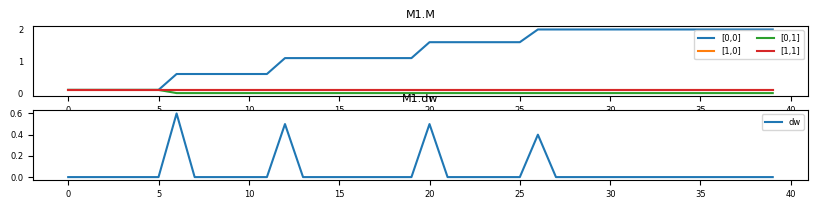

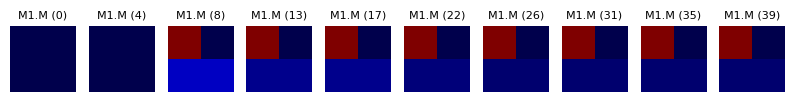

zs: [1 0] zy: [0 1]


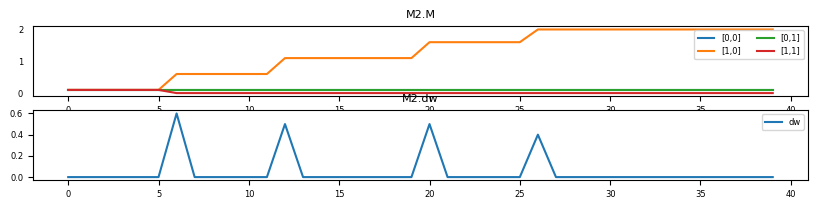

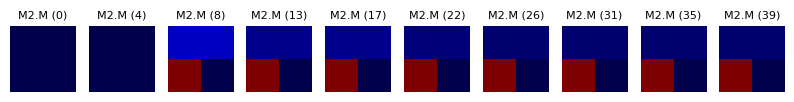

zs: [1 0] zy: [1 1]


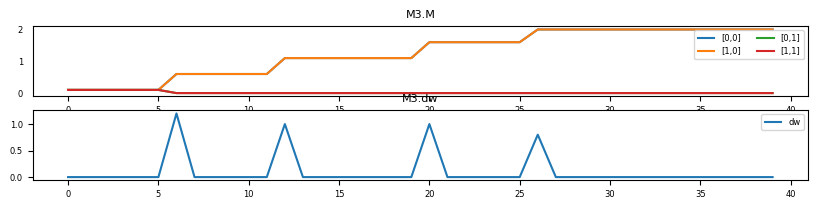

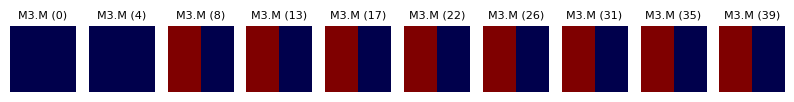

In [59]:
def test_LIConnector_ops():
    M = np.array([[1,0],[0,1]], dtype=float)
    M = LIConnector(M=M)
    s = np.array([1,0], dtype=float)    
    y = M @ s
    print('s:', s, 'y:', y)
    
def test_LIConnector(T=10, log_step=1, debug=True, plot=False):
    params = SSNNParams(g=1, e_err=5, t_p=2, pmax=1, e_z=2, c_k=3, c_in=0, c_out=0, cmin=0, cmax=2)
    print(params)
    def _test(zs, zy, name):
        M = np.array([[.1,.1], [.1, .1]])
        Mc = LIConnector(M=M, name=name, params=params)
        Cp, Cn=None,None 
        Cp_, Cn_, Zp_, Zn_, Wp_, Wn_, dM_, dMp_, dMn_ = np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape)
        for t in range(T):
            debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
            if debug_:
                print(f't={t}', 'zs:', zs, 'zy:', zy)
            M, Cp, Cn, dM, dMp, dMn, Zp, Zn, Wp, Wn = Mc(zs, zy)
            if debug_:
                xdisplay(Markup('M', M), Markup('Cp', Cp), Markup('Cn', Cn), Markup('Zp', Zp), Markup('Zn', Zn), Markup('Wp', Wp), Markup('Wn_', Wn), Markup('dM', dM), Markup('dMp', dMp), Markup('dMn', dMn))
            Cp_ += Cp
            Cn_ += Cn
            Zp_ += Zp
            Zn_ += Zn
            Wp_ += Wp
            Wn_ += Wn
            dM_ += dM
            dMp_ += dMp
            dMn_ += dMn
            Mc.sample()
        if debug:
            print('zs:', zs, 'zy:', zy)
            xdisplay(Markup('M', M), Markup('Cp_', Cp_), Markup('Cn_', Cn_), Markup('Zp_', Zp_), Markup('Zn_', Zn_), Markup('Wp_', Wp_), Markup('Wn_', Wn_), Markup('dM_', dM_), Markup('dMp_', dMp_), Markup('dMn_', dMn_))
        if plot:
            Mc.render()
    zs = np.array([1,0])
    zy = np.array([1,0])
    _test(zs, zy, name='M1')
    zy = np.array([0,1])
    _test(zs, zy, name='M2')
    zy = np.array([1,1])
    _test(zs, zy, name='M3')

test_LIConnector_ops()
test_LIConnector(T=20, log_step=-1, plot=True)

# Sensors

In [6]:
def _test_signal(n=2, dc=False, T=100, L=1, value=1):
    if dc:
        return signal_dc(n, T=T, s=0, value=value)
    else:
        return signal_pulse(n, T=100, L=L, s=[i for i in range(0,n)], value=1)
    
def _test_nn(nn, ss=None, T=100, n=None, options=None, plot=True, log_step=1):
    if ss is None:
        if n is None:
            n = nn.shape[-1]
        ss = _test_signal(n, dc=False, T=T, L=1, value=1)
    if T is None:
        T = ss.shape[0]
    for t in range(0,T):
        s = ss[t]
        debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
        _ = nn(s)
        if debug_:
            print(f't={t}')
            nn.log(options=options)
    if plot:
        nn.render(options=options)

SSensorParams({'g': 1, 'e_err': 5, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2, 'pf': 1, 'pmax': 1, 'input_size': None})


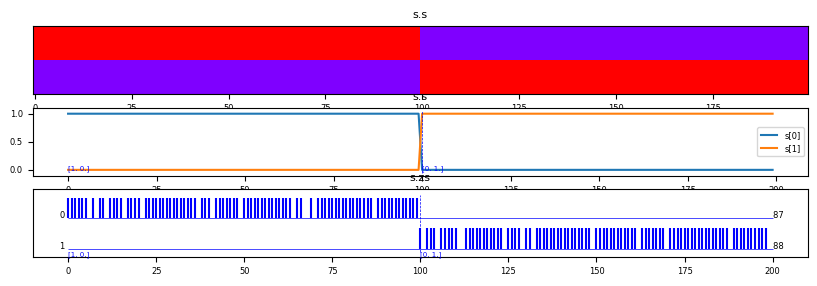

In [155]:
def test_sensor(n = 2, T=100, L=1, ss=None, log_step=1, options=None, plot=False):
    params = SSensorParams()
    print(params)
    sensor = SSensor(n=n, name='s', params=params, auto_sample=True, monitor=True, viewer=True)
    if ss is None:
        ss = _test_signal(n, dc=False, T=T, L=L, value=1)
    if T is None:
        T = ss.shape[0]
    for t in range(0,T):
        if ss is not None:
            sx = ss[t] 
        debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
        s,zs = sensor(sx)
        if debug_:
            print(f't={t}')
            sensor.log(options)
    sensor.render(options)
    return sensor

sensor = test_sensor(T=200, L=2, log_step=-1, plot=True, options={})


# LinearLayer

SSensorParams({'g': 1, 'e_err': 5, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2, 'pf': 1, 'pmax': 1, 'upsample_method': <UpsampleMethod.REPEAT: 2>})
[[0. 1.]
 [1. 0.]]
t=0
s: sx=[1. 0.]; s=[1. 0.]  -> zs=[1 0]
nn: s=[1. 0.] | zs=[1 0]-> y=[0. 1.] | zy=[0. 1.]
t=199
s: sx=[0. 1.]; s=[0. 1.]  -> zs=[0 1]
nn: s=[0. 1.] | zs=[0 1]-> y=[1. 0.] | zy=[1. 0.]


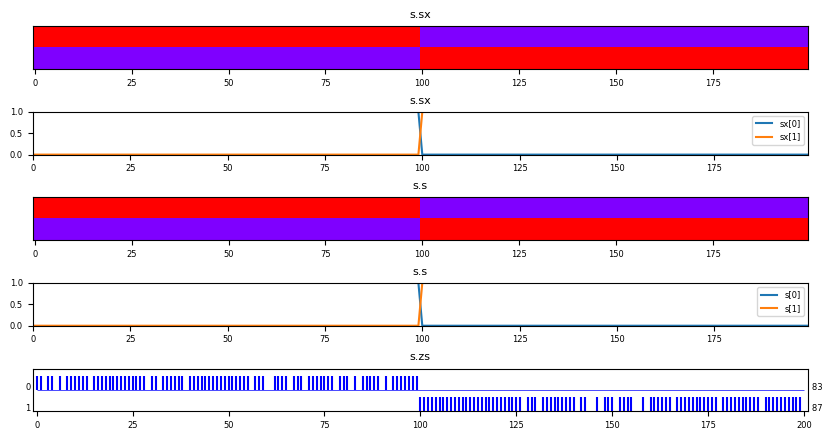

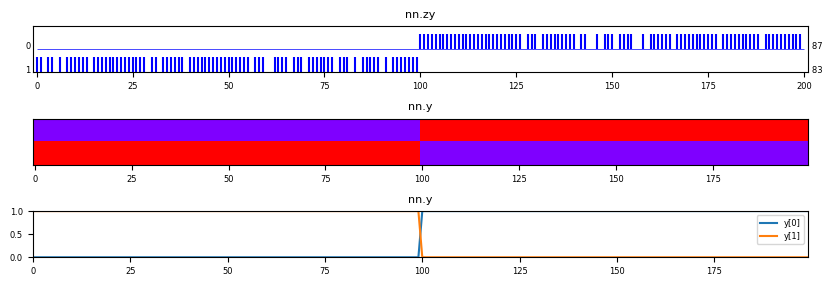

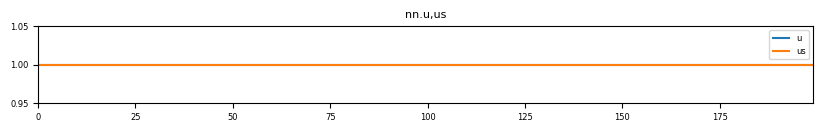

{'name': None, 'ref': <spikeml.core.snn.LinearLayer object at 0x00000133E62E9960>, 'E': 0, 'y': [array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), ar

In [24]:
def test_linear_layer(n = 2, T=100, L=1, ss=None, log_step=1, options=None, plot=False):
    params = SSensorParams()
    print(params)
    sensor = SSensor(n=n, name='s', params=params, auto_sample=True, monitor=True, viewer=True)
    if ss is None:
        ss = _test_signal(n, dc=False, T=T, L=L, value=1)
    if T is None:
        T = ss.shape[0]
    M = np.ones((n,n)) - np.identity(n)
    print(M)
    layer = LinearLayer(M, name='nn', params=params, auto_sample=True, monitor=True, viewer=True)
    for t in range(0,T):
        if ss is not None:
            sx = ss[t] 
        debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
        s,zs = sensor(sx)
        y,zy = layer((s,zs))
        if debug_:
            print(f't={t}')
            sensor.log(options)
            layer.log(options)
                        
    if plot:
        sensor.render(options)
        layer.render(options)
    return layer

layer = test_linear_layer(T=200, L=2, log_step=0, plot=True, options={'log.matrix': False})
print(vars(layer.monitor))


# SSNN, SNN

t=0
nn: s=[1. 0.] | zs=[1 0] -> y=[0.0882 0.    ] | zy=[1 0]


t=19
nn: s=[1. 0.] | zs=[1 0] -> y=[1. 0.] | zy=[1 0]


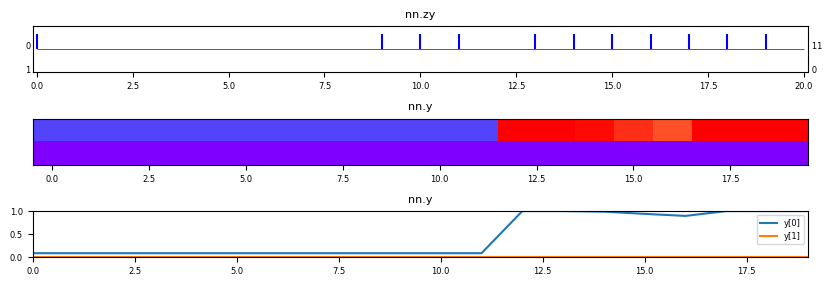

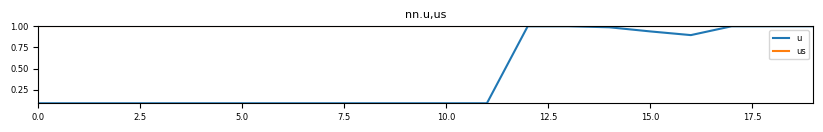

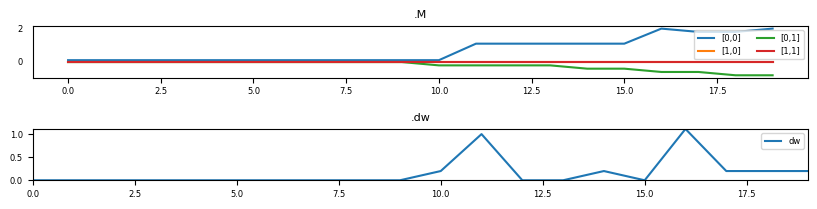

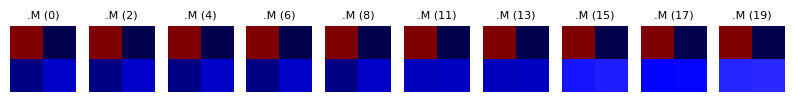

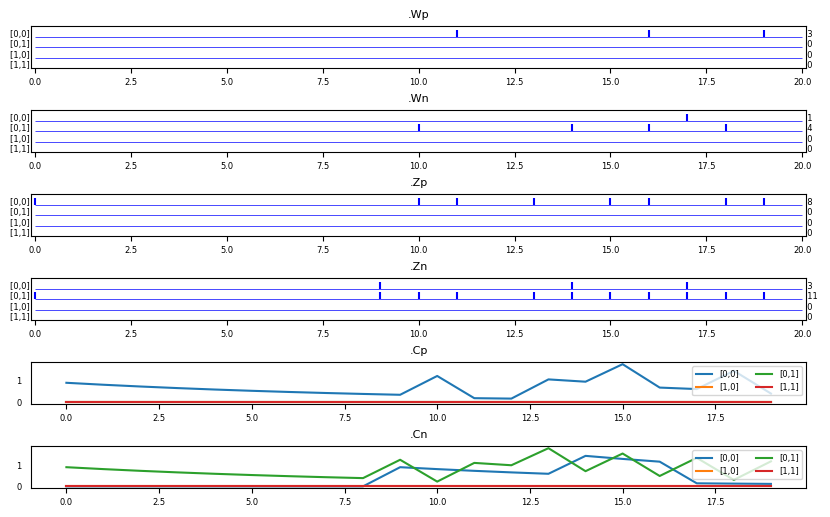

In [9]:
def test_ssnn(T=10, log_step=1, debug=True, plot=False):
    params = SSNNParams()
    n = 2
    cparams = ConnectorParams(size=n, mean=0, sd=.1)
    M = LIConnector(params = cparams)
    nn = SSNN(name='nn', M=M, params=params, auto_sample=True, monitor=True, viewer=True)
    s = np.zeros(n)
    s[0] = 1
    for t in range(0,T):
        debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
        _ = nn(s)
        if debug_:
            print(f't={t}')
            nn.log()
    if plot:
        nn.render()


test_ssnn(T=20, log_step=0, plot=True)

SNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0.1,sd=0.0,size=2,g=1,e_err=5,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,t_x=20,k_x=0.5,r_sd=0.1
$$$$$ <spikeml.core.snn_monitor.SNNMonitor object at 0x000001DDF81F93F0> <spikeml.core.snn.SNN object at 0x000001DDF81FBB50>
Monitor
(<class 'spikeml.core.snn_monitor.SNNMonitor'>, <class 'spikeml.core.monitor.Monitor'>, <class 'object'>)
t=0
nn: s=[1. 0.] | zs=[0 0] ; r=[0.02878755 0.05892338] -> x=[0.02734817 0.05597721]; k_x=[0.02734817 0.05597721] -> y=[0. 0.] | zy=[0 0]


t=999
nn: s=[1. 0.] | zs=[1 0] ; r=[-0.06724127  0.02762571] -> x=[19.5889516  20.21624546]; k_x=[19.5889516  20.21624546] -> y=[0. 0.] | zy=[1 1]


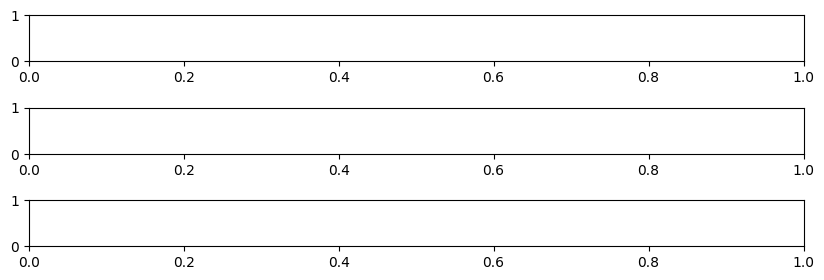

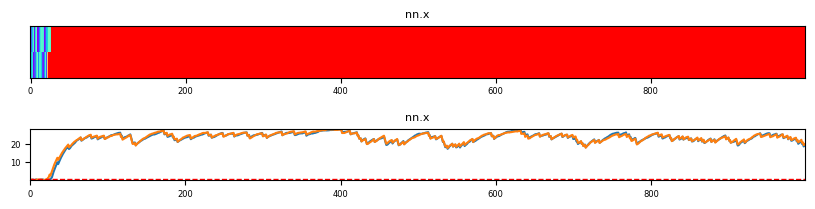

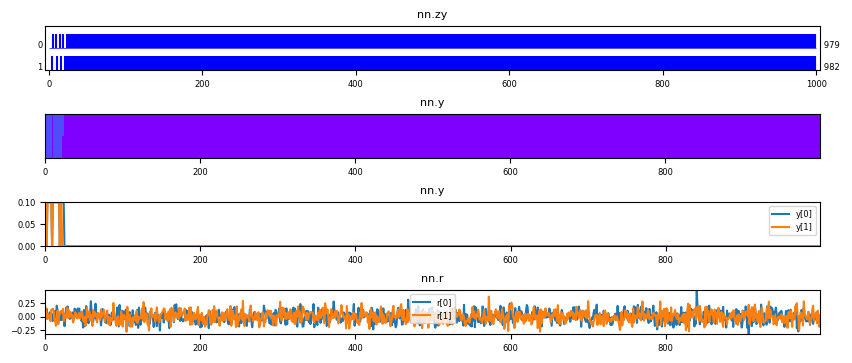

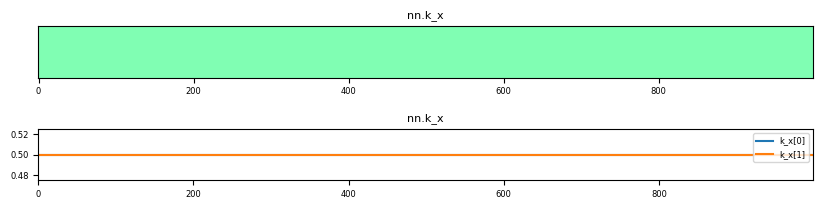

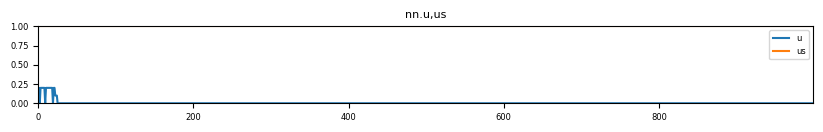

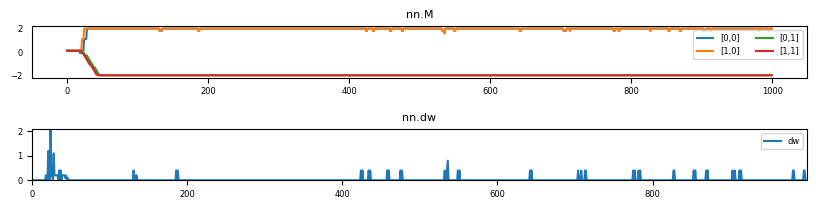

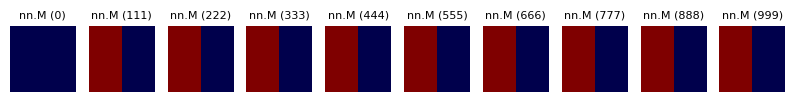

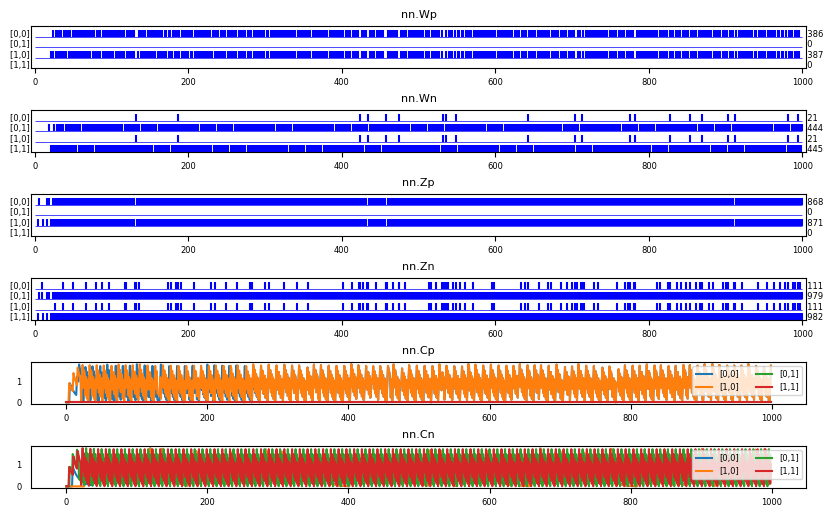

In [102]:
def test_snn(T=1, log_step=1, options=None, debug=True, plot=False):
    params = SNNParams(k_x=.5, r_sd=0.1, size=2, mean=.1, sd=0)
    print(params.fmt())
    M = LIConnector(params = params, name='nn', monitor=True, viewer=True)
    #M = LinearConnector(M, name='nn', monitor=True, viewer=True)
    global nn
    sensor = SSensor(name='s', params=params, auto_sample=True, monitor=True, viewer=True)
    nn = SNN(name='nn', M=M, params=params, auto_sample=True, monitor=True, viewer=True)
    s = np.zeros(nn.x.shape[0])
    s[0] = 1
    for t in range(0,T): 
        debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
        _ = nn(s)
        if debug_:
            print(f't={t}')
            nn.log(options)
    nn.render(options)
    #compute_final(nn.monitor)
    return nn

nn = test_snn(T=1000, log_step=0, plot=True, options={'log.matrix': True, 'render.matrix': True})


In [65]:
def compute_final(monitor):
    zy = monitor.zy
    zy = np.array(zy).T
    print(zy)
    
    cov = np.cov(zy[0], zy[1]) #[0,1]	measure of joint variability	unbounded
    cc = np.corrcoef(zy[0], zy[1])#[0,1]
    print(f'cov:\n{cov}')
    print(f'cc:\n{cc}')
    print(f'cov: {cov[0,1]:.3f} ; cc:{cc[0,1]:.3f}')

#compute_final(nn.monitor)


# Chains

In [18]:
import spikeml as sml
from spikeml.core.signal import signal_dc, signal_pulse, encode1_onehot, encode_onehot, signal_ranges, mean_per_input
from spikeml.core.matrix import matrix_split, normalize_matrix, _mult, cmask, cmask2, matrix_init, matrix_init2
from spikeml.core.monitor import Monitor
from spikeml.core.spikes import pspike, spike
from spikeml.core.params import Params, NNParams, ConnectorParams, SpikeParams, SSensorParams, SNNParams, SSNNParams
from spikeml.core.base import Component, Module, Fan, Composite, Chain
from spikeml.core.snn import Layer, SimpleLayer, SNN, SSNN, SSensor, DSSNN, Connector, LinearConnector, RateConnector, LIConnector, LIConnector2
from spikeml.core.chain import make_snn_chain, make_ssnn_chain, chain_validate
from spikeml.core.snn import ssnn_apply_update
from spikeml.core.feedback import compute_error, xcompute_error, compute_sg
from spikeml.core.run import run, nrun, Context
from spikeml.core.snn_monitor import SSensorMonitor, SNNMonitor, SSNNMonitor, ConnectorMonitor, LIConnectorMonitor
from spikeml.core.snn_viewer import  SSensorMonitorViewer, SNNMonitorViewer, SSNNMonitorViewer, ConnectorMonitorViewer, LIConnectorMonitorViewer, ErrorMonitorViewer


In [7]:
params = SNNParams(pmax=.5)
print(params.fmt())
sensor_params = SSensorParams.model_validate(params.model_dump())
print(sensor_params.fmt())


SNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0,sd=0.1,g=1,e_err=5,vmin=0,vmax=1,e_z=2,pf=1,pmax=0.5,t_x=20,k_x=1,r_sd=0.01
SSensorParams:g=1.0,e_err=5.0,vmin=0.0,vmax=1.0,e_z=2.0,pf=1.0,pmax=0.5,upsample_method=UpsampleMethod.REPEAT


In [20]:
def test_snn_chain():
    params = SSNNParams()
    print(params.fmt())
    def _test_chain(size, n):
        nn = make_ssnn_chain(size=size, params=params)
        s = np.ones(n)
        chain_validate(nn)
        print('->', s)
        y, zy = nn(s)
        print('<-', y, zy)
        nn.log()
        print('-'*30)
    size = [2, 2]
    _test_chain(size, 2)
    size = [4, 2]
    _test_chain(size, 2)
    size = [4, 6,2]
    _test_chain(size, 2)

test_snn_chain()

SSNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0,sd=0.1,g=1,e_err=5,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,t_b=20,e_b=2
<spikeml.core.snn.SSensor object at 0x000001A2076A1210> (2,) OK
<spikeml.core.snn.SSNN object at 0x000001A2076A13C0> (2, 2) OK
-> [1. 1.]
<- [0.     0.0973] [0 0]
nn.s: sx=[1. 1.]; s=[1. 1.]  -> zs=[1 1]
nn.1: s=[1. 1.] | zs=[1 1] -> y=[0.     0.0973] | zy=[0 0]


------------------------------
<spikeml.core.snn.SSensor object at 0x000001A2076A30D0> (4,) OK
<spikeml.core.snn.SSNN object at 0x000001A2076A3340> (2, 4) OK
-> [1. 1.]
<- [0.     0.4045] [0 0]
nn.s: (_sx=[1. 1.]; _s=[1. 1.]) ; sx=[1. 1. 1. 1.]; s=[1. 1. 1. 1.]  -> zs=[1 1 1 1]
nn.1: s=[1. 1. 1. 1.] | zs=[1 1 1 1] -> y=[0.     0.4045] | zy=[0 0]


------------------------------
<spikeml.core.snn.SSensor object at 0x000001A2076A2290> (4,) OK
<spikeml.core.snn.SSNN object at 0x000001A2076A1F60> (6, 4) OK
<spikeml.core.snn.SSNN object at 0x000001A2076A0F40> (2, 6) OK
-> [1. 1.]
<- [5.6921e-03 3.1281e-05] [0 0]
nn.s: (_sx=[1. 1.]; _s=[1. 1.]) ; sx=[1. 1. 1. 1.]; s=[1. 1. 1. 1.]  -> zs=[1 1 1 1]
nn.1: s=[1. 1. 1. 1.] | zs=[1 1 1 1] -> y=[0.     0.0024 0.1168 0.1326 0.     0.0198] | zy=[0 0 1 0 0 0]


nn.2: s=[0.     0.0024 0.1168 0.1326 0.     0.0198] | zs=[0 0 1 0 0 0] -> y=[5.6921e-03 3.1281e-05] | zy=[0 0]


------------------------------


SNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0,sd=0.1,g=1,e_err=5,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,t_x=20,k_x=1,r_sd=0.01
(2, 2)
s: s=[0. 0.] | zs=[0. 0.]
nn.0: s=None | zs=None ; r=[0. 0. 0. 0. 0.] -> x=[0. 0. 0. 0. 0.]; k_x=[0. 0. 0. 0. 0.] -> y=None | zy=None


nn.1: s=None | zs=None ; r=[0. 0.] -> x=[0. 0.]; k_x=[0. 0.] -> y=None | zy=None


<spikeml.core.snn.SSensor object at 0x000002A5E1C15600> (2,) OK
<spikeml.core.snn.SNN object at 0x000002A5E1C153C0> (5, 2) OK
<spikeml.core.snn.SNN object at 0x000002A5E1C15870> (2, 5) OK
----------
t=0
s: s=[1. 0.] | zs=[1 0]
nn.0: s=[1. 0.] | zs=[1 0] ; r=[ 0.01653372 -0.01594851  0.01528664 -0.0004102   0.01519469] -> x=[0.15101696 0.05403733 0.         0.         0.        ]; k_x=[0.15101696 0.05403733 0.         0.         0.        ] -> y=[ 0.1424315   0.0728299  -0.02245855 -0.07873477 -0.11585947] | zy=[0 0 0 0 0]


nn.1: s=[ 0.1424315   0.0728299  -0.02245855 -0.07873477 -0.11585947] | zs=[0 0 0 0 0] ; r=[-0.00608436 -0.00745608] -> x=[0. 0.]; k_x=[0. 0.] -> y=[0. 0.] | zy=[0 0]


t=99
s: s=[1. 0.] | zs=[0 0]
nn.0: s=[1. 0.] | zs=[0 0] ; r=[-0.00575596 -0.02907631 -0.00821467  0.01810133  0.00581909] -> x=[0.87373501 0.32463154 0.         0.01719627 0.00552813]; k_x=[0.87373501 0.32463154 0.         0.01719627 0.00552813] -> y=[0. 0. 0. 0. 0.] | zy=[0 0 0 0 0]


nn.1: s=[0. 0. 0. 0. 0.] | zs=[0 0 0 0 0] ; r=[-0.00120775 -0.00137749] -> x=[0.04575956 0.14535886]; k_x=[0.04575956 0.14535886] -> y=[0. 0.] | zy=[0 0]


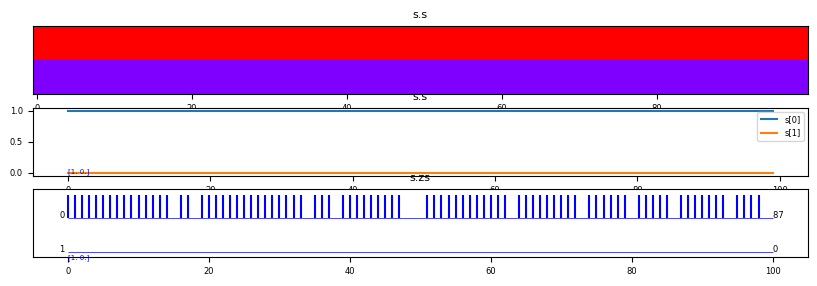

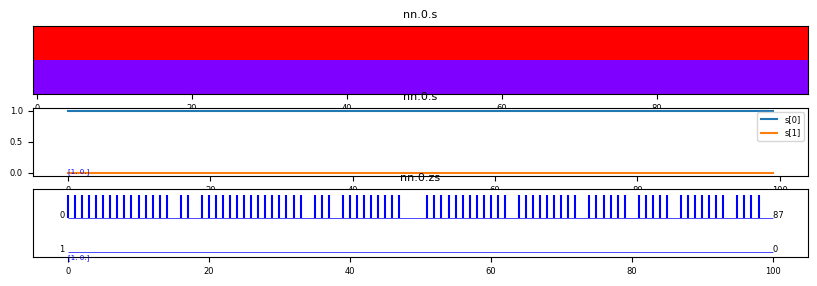

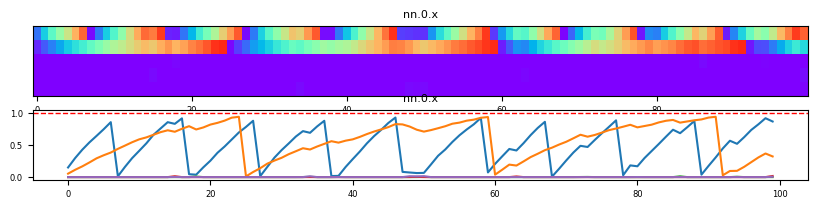

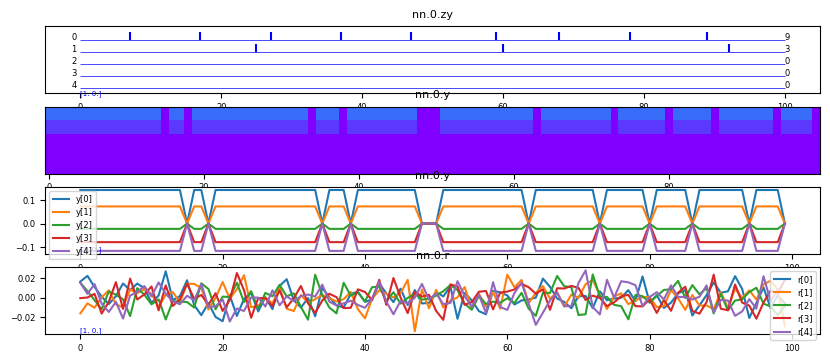

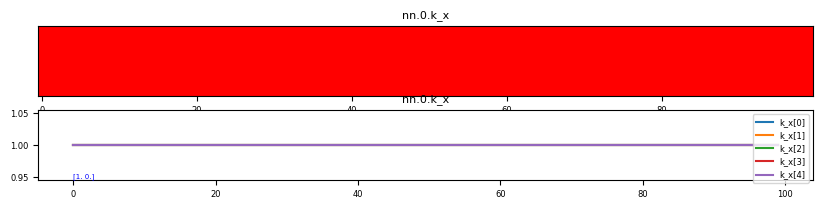

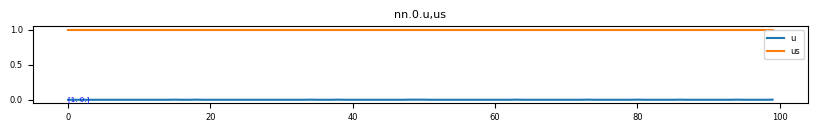

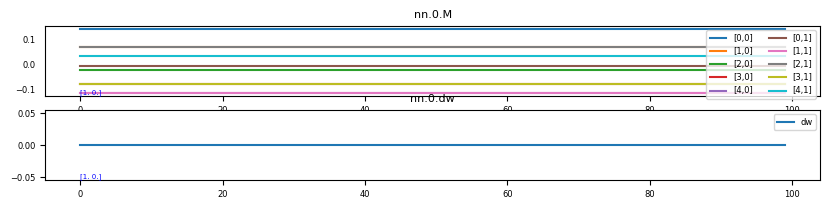

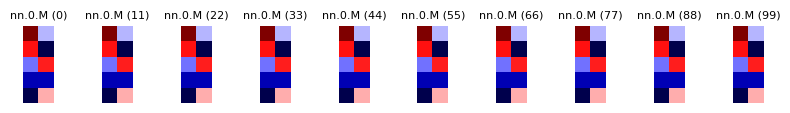

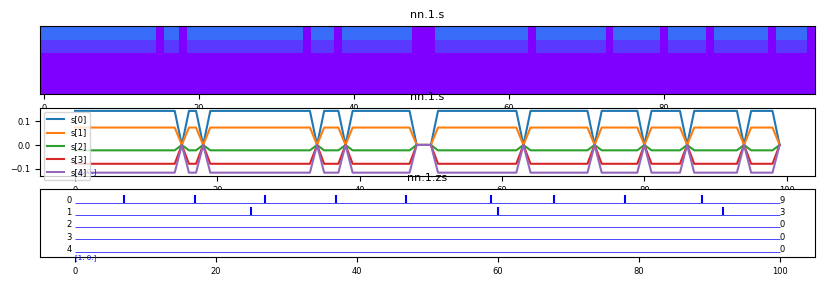

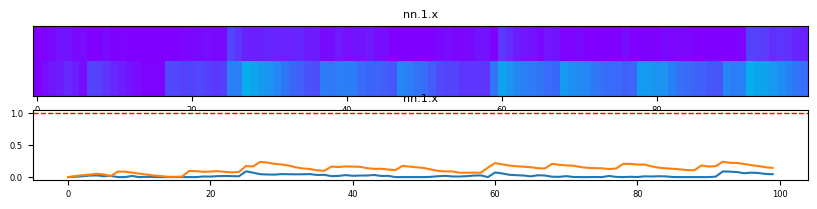

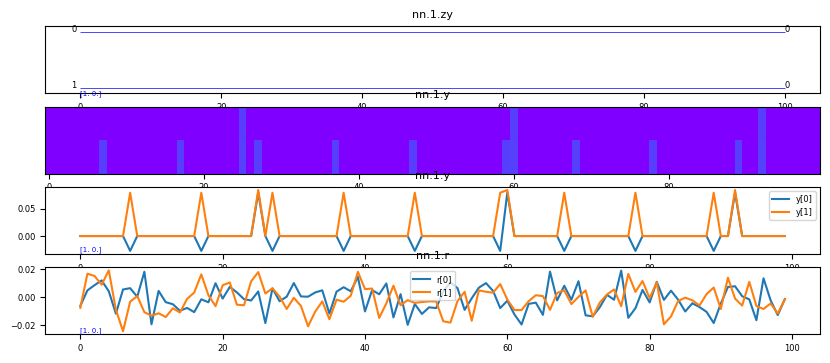

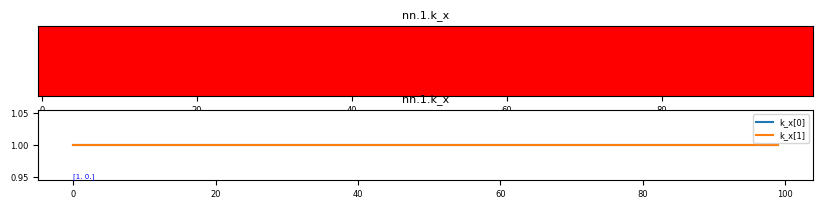

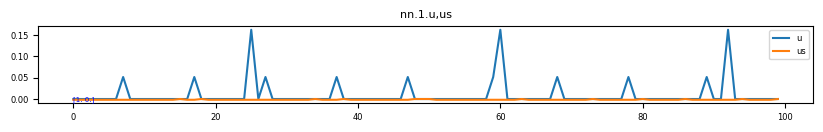

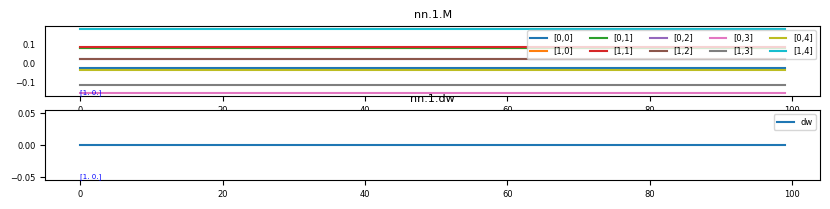

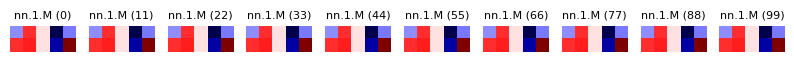

In [ ]:
def test_snn_chain(size=None, T=10, ss=None, params=None, options=None, plot=True, log_step=1):
    params = SNNParams()
    print(params.fmt())
    nn = make_snn_chain(size=size, params=params)
    print(nn.shape)
    nn.log()
    chain_validate(nn)
    print('-'*10)
    _test_nn(nn, T=T, options=options, plot=plot, log_step=log_step)
    return nn

test_chain()
    
#SIZE=2
#SIZE=[2,2]
SIZE=[2,2]
#SIZE=[(3,2),3,2])
#SIZE=[(2,3),(3,3), (3,2)])
test_snn_chain(size=SIZE, T=100, log_step=0)



SSNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0,sd=0.1,g=1,e_err=5,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,t_b=20,e_b=2
nn.s: sx=[0. 0.]; s=[0. 0.]  -> zs=[0. 0.]
nn.1: s=None | zs=None -> y=None | zy=None


<spikeml.core.snn.SSensor object at 0x000001A207672FB0> (2,) OK
<spikeml.core.snn.SSNN object at 0x000001A207670E20> (2, 2) OK
----------
t=0
nn.s: sx=[0.5 0. ]; s=[0.5 0. ]  -> zs=[1 0]
nn.1: s=[0.5 0. ] | zs=[1 0] -> y=[0. 0.] | zy=[0 0]


t=99
nn.s: sx=[0.5 0. ]; s=[0.5 0. ]  -> zs=[1 0]
nn.1: s=[0.5 0. ] | zs=[1 0] -> y=[0. 0.] | zy=[0 0]


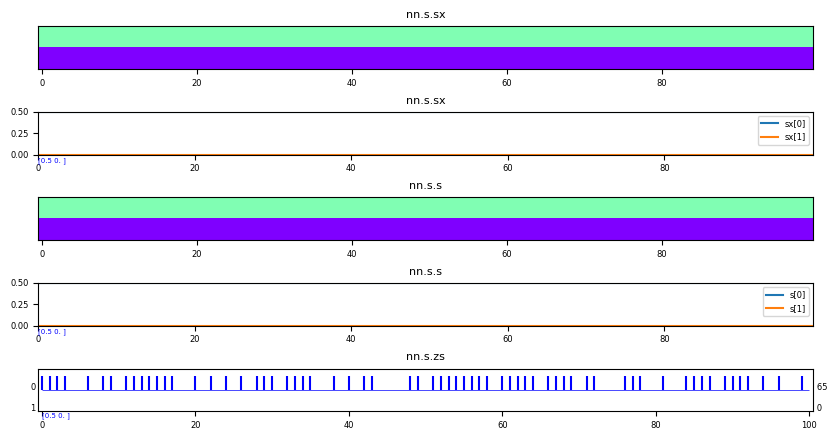

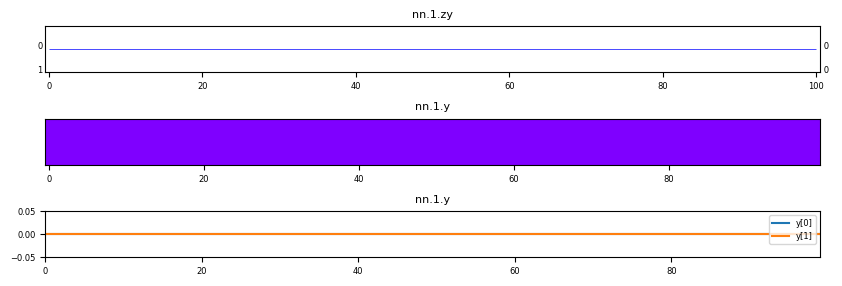

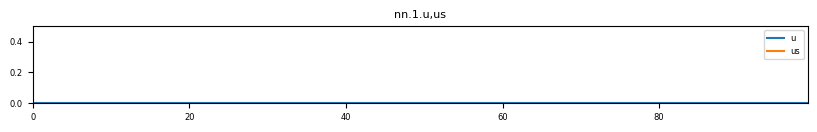

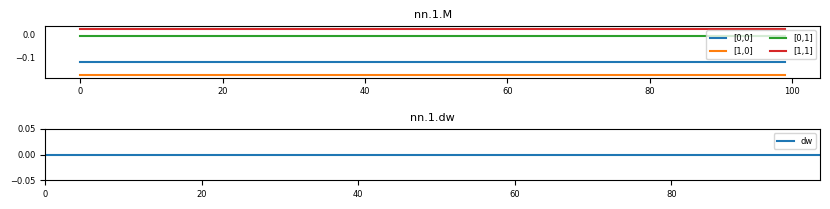

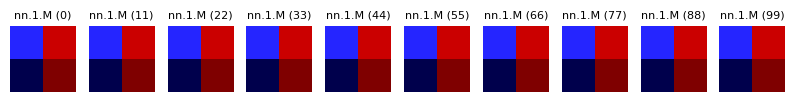

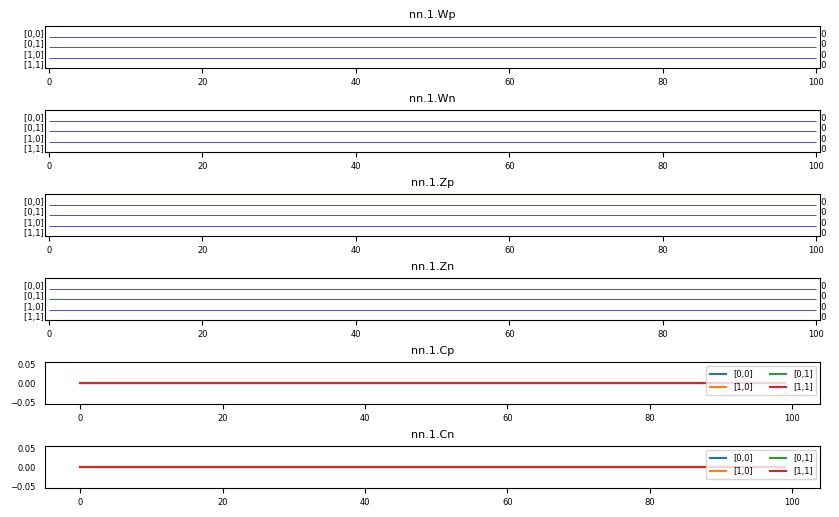

In [23]:
def test_ssnn_chain_n(size=None, T=None, ss=None, params=None, options=None, plot=True, log_step=1, debug=False):
    params = SSNNParams()
    print(params.fmt())
    nn = make_ssnn_chain(size=size, params=params)
    nn.log()
    chain_validate(nn)
    print('-'*10)
    n = nn.shape[-1]
    ss = signal_pulse(n, T=100, L=4, s=[i for i in range(0,n)], value=.5)
    _test_nn(nn, ss=ss, options=options, plot=True, log_step=log_step)

SIZE=[2,2]
test_ssnn_chain_n(size=SIZE, T=10, log_step=0)


# SSNN Feedback 

In [140]:
def test_ssnn_apply_update(T=1, N=1, size=2, R=1, ss=None, mean=.1, sd=0, feedback=True, params=None, log_step=1, debug=True, quite=False):
    if params is None:
        params = SSNNParams(g=1, e_err=5, t_p=1, t_d=5, pmax=1, e_z=2, c_k=3, c_in=0, c_out=0, cmin=0, cmax=2)
    if not quite:
        print(params)
    #params = SSNNParams(pmax=.5, c_k=2, t_p=1, t_d=3, t_b=0, t_tdp=5, e_z=3, c_in=0, c_out= 0)
    #print(params)
    cparams = ConnectorParams(size=size*R, mean=mean, sd=sd, c_in=params.c_in, c_out=params.c_out)
    M = matrix_init(cparams)
    M__,Cp__, Cn__, Zp__, Zn__, Wp__, Wn__, dM__, dMp__, dMn__ = np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape)
    d = size*R
    y__, zy__, zs__ = np.zeros(d),np.zeros(d),np.zeros(d)
    if ss is None:
        ss = signal_pulse(size, T=100, L=4, s=[i for i in range(0,size)], value=.5)
    results = []
    for k in range(N): 
        if debug:
            print(f'Repeat: {k+1}/{N}')
        Cp, Cn =None,None 
        sg = 1
        sx = ss[0]
        sx_ = np.repeat(sx, R) if R>1 else sx        
        sm = sx_
        sg_ = []
        err_ = []
        M = matrix_init(cparams)
        Cp_, Cn_, Zp_, Zn_, Wp_, Wn_, dM_, dMp_, dMn_ = np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape),np.zeros(M.shape)
        y_, zy_, zs_ = np.zeros(d),np.zeros(d),np.zeros(d)
        for t in range(T):
            debug_ = log_step>=0 and (t==0 or t==T-1 or (log_step>0 and t%log_step==0))
            if debug_:
                print(f't={t}')
            y, zy, zs, M, Cp, Cn, dM, dMp, dMn, Zp, Zn, Wp, Wn = ssnn_apply_update(M, Cp, Cn, sm, zs=None, b=None, params=params, debug=debug_)
            y_ += y
            zy_ += zy
            zs_ += zs
            Cp_ += Cp
            Cn_ += Cn
            Zp_ += Zp
            Zn_ += Zn
            Wp_ += Wp
            Wn_ += Wn
            if dM is not None:
                dM_ += dM
            if dMp is not None:
                dMp_ += dMp
            if dMn_ is not None:
                dMn_ += dMn
            sx= ss[t % ss.shape[0]]
            sx_ = np.repeat(sx, R) if R>1 else sx
            s = sx_
            if feedback:
                err = xcompute_error(sx, y, R=R, method='sum+clip')
                #err = compute_error(sx, zy, R)
                sg = compute_sg(err, params)
                s = sx_ + params.g*zy
                sm = np.clip(s*sg, params.vmin, params.vmax)
                if debug_:
                    print(f'sx: {sx_} y: {y}', f'-> err: {err:.2f}', f'; sg: {sg:.2f}', f'=> s: {s}', f'=> sm: {sm}')
                sg_.append(sg)
                err_.append(err)
            else:       
                if debug_:
                    print(f'sx: {sx_} y: {y}')

        sg_ = np.array(sg_)
        err_ = np.array(err_)
        if debug:
            xdisplay(Markup('M', M), Markup('Cp_', Cp_), Markup('Cn_', Cn_), Markup('Zp_', Zp_), Markup('Zn_', Zn_), Markup('Wp_', Wp_), Markup('Wn_', Wn_), Markup('dM_', dM_), Markup('dMp_', dMp_), Markup('dMn_', dMn_))
            print('y_:', y_, 'zy_:', zy_, 'zs_:', zs_, f'sg: {sg_.min():.2f} {sg_.max():.2f}', f'err: {err_.min()} {err_.max()}')
        y__ += y_
        zy__ += zy_
        zs__ += zs_
        M__ += M
        Cp__ += Cp_
        Cn__ += Cn_
        Zp__ += Zp_
        Zn__ += Zn_
        Wp__ += Wp_
        Wn__ += Wn_
        dM__ += dM_
        dMp__ += dMp_
        dMn__ += dMn_
        results.append(M)
        
    y__ /= N
    zy__ /= N
    zs__ /= N
    M__ /= N
    Cp__ /= N
    Cn__ /= N
    Zp__ /= N
    Zn__ /= N
    Wp__ /= N
    Wn__ /= N
    dM__ /= N
    dMp__ /= N
    dMn__ /= N
    if not quite:
        print('y__:', y__, 'zy__:', zy__, 'zs__:', zs__)
        #if R==1:
        if R<=8:
            xdisplay(Markup('M__', M__), Markup('Cp__', Cp__), Markup('Cn__', Cn__), Markup('Zp__', Zp__), Markup('Zn__', Zn__), Markup('Wp__', Wp_), Markup('Wn__', Wn__), Markup('dM__', dM__), Markup('dMp__', dMp__), Markup('dMn__', dMn__))
        #err = -M__[0,0]-M__[1,1]+M__[1,0]+M__[0,1]
        err = float(-2*M__.trace() + M__.sum())
        print('->', err, err)
        print(np.max(M__, axis=1), np.argmax(M__, axis=1))
        if R>1:
            M = M__.reshape(size, R, size, R).sum(axis=(1, 3))
            xdisplay(Markup('M', M))
            err = float(-2*M.trace() + M.sum())
            print('->', err, err)
            print(np.max(M, axis=1), np.argmax(M, axis=1))

    return results

#test_cov_update()


params = SSNNParams(g=1, e_err=5, t_p=1, t_d=10, pmax=1, e_z=2, c_k=2, t_c=5, c_in=0, c_out=0, cmin=0, cmax=2)
results = test_ssnn_apply_update(T=4000, N=20, R=1, size=2, params=params, log_step=-1, debug=False)


SSNNParams({'c_k': 2.0, 't_c': 5.0, 't_p': 1.0, 't_d': 10.0, 'c_in': 0.0, 'c_out': 0.0, 'cmin': 0.0, 'cmax': 2.0, 'mean': 0, 'sd': 0.1, 'size': None, 'g': 1.0, 'e_err': 5.0, 'vmin': 0, 'vmax': 1, 'name': None, 'e_z': 2.0, 'pf': 1, 'pmax': 1.0, 't_b': 20, 'e_b': 2})
y__: [34.6208 78.0913] zy__: [ 66.9  116.55] zs__: [513.55 526.25]


-> -0.08999999999999997 -0.08999999999999997
[0.045 0.1  ] [0 1]


In [ ]:
def make_ssnn2(name='nn', params=None, size=None, M=None, mean=0.0, sd=0.1):
    if M is None:
        if not isinstance(mean, tuple):
            M = matrix_init(size, mean=mean, sd=sd, c_in=params.c_in, c_out=params.c_out)
        else:
            sdp,sdn = sd if isinstance(sd, tuple) else sd,sd
            Mp = np.abs(matrix_init(size, mean=mean[0], sd=sdp, c_in=params.c_in, c_out=params.c_out))
            Mn = -np.abs(matrix_init(size, mean=mean[1], sd=sdn, c_in=params.c_in, c_out=params.c_out))
            M = (Mp,Mn)
        #print(M)
    nn = SSNN(name=name, M=M, params=params, auto_sample=False, monitor=True, viewer=True)
    return nn

def make_snn2(name='nn', params=None, size=None, M=None, mean=0.0, sd=0.1):
    M = matrix_init(size, mean=mean, sd=sd, c_in=params.c_in, c_out=params.c_out)
    nn = SNN(name=name, M=M, params=params, auto_sample=False, monitor=True, viewer=True)
    return nn

def test_run_ssnn2(T=None, ss=None, params=None, size=None, M=None, mean=0.0, sd=0.1, feedback=True, callback=None, plot=True, log_step=1, options=None, debug=False):
    if debug:
        print(params)
    nn = make_ssnn(name=f'nn', params=params, size=ss.shape[-1], M=M, mean=mean, sd=sd)
    result = run(nn, T=T, ss=ss, params=params, feedback=feedback, callback=callback, plot=plot, log_step=log_step, options=options, debug=debug)
    return result
